In [1]:
model_file = "../models/europe.json"
data_dir   = "data/TOPF_run"

"data/TOPF_run"

In [2]:
using TemperateOptimalPowerFlow
using DataDrop, Plots

# Test setup

Make a temporary copy of the run directory:

In [3]:
test_dir = "data/TOPF_test"

if isdir(test_dir)
    rm(test_dir, recursive=true)
end

mkdir(test_dir)

for file in readdir(data_dir)
    cp("$(data_dir)/$file", "$(test_dir)/$file")
end

# Small-scale test

Reduce the number of times steps:

In [4]:
scale_down(test_dir, 12)

[2024-07-23 11:59:12]  Scaling down file 'data/TOPF_test/P_total.h5' from 8736 to 12 time steps
[2024-07-23 11:59:12]  Scaling down file 'data/TOPF_test/linear_line_cost.h5' from 8736 to 12 time steps
[2024-07-23 11:59:13]  Scaling down file 'data/TOPF_test/linear_gen_cost.h5' from 8736 to 12 time steps
[2024-07-23 11:59:13]  Scaling down file 'data/TOPF_test/P_load.h5' from 8736 to 12 time steps
[2024-07-23 11:59:13]  Scaling down file 'data/TOPF_test/P_nondispatch.h5' from 8736 to 12 time steps


Perform OPF:

In [5]:
using Ipopt
# using Gurobi

In [6]:
compute(test_dir, "P_result_12_1")

[2024-07-23 11:59:15]  OPF with 12 time steps, 771 generators, and 159 ramp constraints (cyclic)
[2024-07-23 11:59:15]   -> checking model
[2024-07-23 11:59:15]   -> defining optimisation problem
[2024-07-23 11:59:15]   -> optimizing

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

[2024-07-23 12:01:38]   -> exporting results
[2024-07-23 12:01:38]  Saving results to file 'data/TOPF_test/P_result_12_1.h5'


The resulting power at each generator for each time step can be obtained with
(note that this includes the non-dispatchable generators as well):

In [7]:
gen = retrieve_gen_results(test_dir, "P_result_12_1")

815×12 Matrix{Float64}:
 1.14       1.14       1.10452    0.885186  …  0.791265   1.13363    1.14
 0.746853   0.57321    0.585205   0.1473       0.0681478  0.265083   0.70946
 0.515837   0.509893   0.469603   0.330612     0.321817   0.435899   0.514618
 0.466494   0.390522   0.362509   0.173681     0.188983   0.298416   0.43764
 2.70213    2.4823     2.4919     2.12503      2.2192     2.35379    2.62272
 1.58908    1.48395    1.05162    0.823075  …  0.897166   1.3888     1.52515
 2.5051     2.26024    2.37539    2.21625      2.21675    2.14131    2.66928
 1.46199    0.872508   0.652972   0.284302     0.293892   0.60163    1.18711
 0.488071   0.453001   0.351961   0.0          0.480073   0.221927   0.656257
 0.737852   0.633161   0.479138   0.0          0.0        0.41486    0.533529
 0.0196305  0.0        0.180439   0.0       …  0.0        0.0        0.266372
 0.787293   0.597946   0.328265   0.411208     0.0        0.459741   1.0294
 0.656696   0.691979   0.640518   0.0          0.123

Examine the power injections at every bus and verify that they add up to zero at every time step:

In [8]:
injections = retrieve_injections(test_dir, "P_result_12_1")
sum(injections, dims=1)

1×12 Matrix{Float64}:
 -1.59162e-12  2.84217e-13  -4.54747e-13  …  1.02318e-12  7.95808e-13

The power flowing through the lines can be obtained with:

In [9]:
retrieve_line_flows(test_dir, "P_result_12_1")

8375×12 Matrix{Float64}:
 -0.14253     -0.194016    -0.204952    …  -0.133007   -0.238894   -0.201853
 -0.14253     -0.194016    -0.204952       -0.133007   -0.238894   -0.201853
 -0.0556288    0.0299774    0.0425983       0.333368    0.212507   -0.0144295
 -0.0556288    0.0299774    0.0425983       0.333368    0.212507   -0.0144295
 -0.0100436    0.0258672    0.00458783     -0.261333   -0.12439    -0.0279631
 -0.08936     -0.122411    -0.110789    …   0.0293722  -0.0644272  -0.0759391
 -0.114292    -0.0913256   -0.0576341       0.0534949  -0.0060708  -0.112134
 -0.319515    -0.329546    -0.31494        -0.361465   -0.374137   -0.348302
  0.534378     0.514462     0.479029        0.514921    0.558757    0.535377
 -0.230717    -0.270393    -0.257817       -0.317422   -0.314322   -0.279779
 -0.230717    -0.270393    -0.257817    …  -0.317422   -0.314322   -0.279779
  0.519055     0.516043     0.499741        0.574377    0.569629    0.543725
  0.0985831   -0.00914139  -0.0297416      -0.1

### Compare different partitioning

In [10]:
compute(test_dir, "P_result_3x4_1", [3, 4])

[2024-07-23 12:01:42]  Partitioning a dataset of 12 time steps into 3 chunks of 4 time steps
[2024-07-23 12:01:42]  0/3 OPF with 3 time steps, 771 generators, and 159 ramp constraints (cyclic)
[2024-07-23 12:01:42]       -> checking model
[2024-07-23 12:01:42]       -> defining optimisation problem
[2024-07-23 12:01:42]       -> optimizing
[2024-07-23 12:01:45]       -> exporting results
[2024-07-23 12:01:46]  1/3 OPF with 4 time steps, 771 generators, and 159 ramp constraints (fixed boundaries)
[2024-07-23 12:01:46]       -> checking model
[2024-07-23 12:01:46]       -> defining optimisation problem
[2024-07-23 12:01:46]       -> optimizing
[2024-07-23 12:01:52]       -> exporting results
[2024-07-23 12:01:53]  Estimated remaining time: 15 s
[2024-07-23 12:01:53]  2/3 OPF with 4 time steps, 771 generators, and 159 ramp constraints (fixed boundaries)
[2024-07-23 12:01:53]       -> checking model
[2024-07-23 12:01:53]       -> defining optimisation problem
[2024-07-23 12:01:53]       ->

In [11]:
compute(test_dir, "P_result_2x2x3_1", [2, 2, 3])

[2024-07-23 12:02:06]  Partitioning a dataset of 12 time steps into 2 chunks of 6 time steps
[2024-07-23 12:02:06]  0/2 OPF with 2 time steps, 771 generators, and 159 ramp constraints (cyclic)
[2024-07-23 12:02:06]       -> checking model
[2024-07-23 12:02:06]       -> defining optimisation problem
[2024-07-23 12:02:06]       -> optimizing
[2024-07-23 12:02:07]       -> exporting results
[2024-07-23 12:02:07]  1/2 Partitioning a dataset of 6 time steps into 2 chunks of 3 time steps
[2024-07-23 12:02:07]  1/2 0/2 OPF with 2 time steps, 771 generators, and 159 ramp constraints (fixed boundaries)
[2024-07-23 12:02:07]           -> checking model
[2024-07-23 12:02:07]           -> defining optimisation problem
[2024-07-23 12:02:07]           -> optimizing
[2024-07-23 12:02:09]           -> exporting results
[2024-07-23 12:02:09]  1/2 1/2 OPF with 3 time steps, 771 generators, and 159 ramp constraints (fixed boundaries)
[2024-07-23 12:02:09]           -> checking model
[2024-07-23 12:02:09]

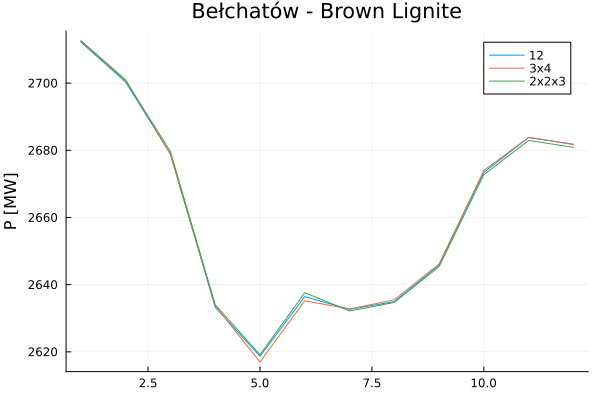

In [12]:
gen_id = 263
gen_name = "Bełchatów - Brown Lignite"

plot()
for partition ∈ ["12", "3x4", "2x2x3"]
    P = DataDrop.retrieve_matrix("$(test_dir)/P_result_$(partition)_1.h5")
    plot!(100 * P[gen_id, :], label=partition, title=gen_name)
end
ylabel!("P [MW]")
# ylims!(0, 3000)

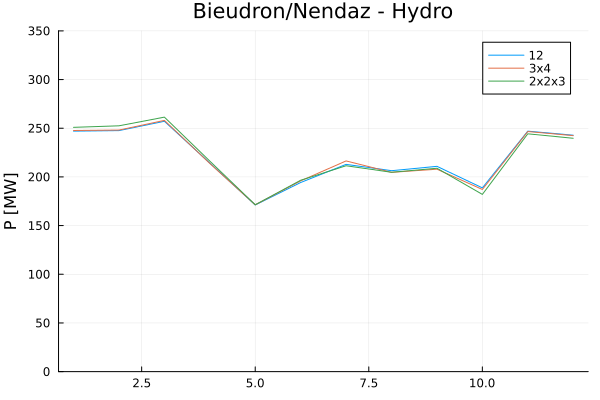

In [13]:
gen_id = 680
gen_name = "Bieudron/Nendaz - Hydro"

plot()
for partition ∈ ["12", "3x4", "2x2x3"]
    P = DataDrop.retrieve_matrix("$(test_dir)/P_result_$(partition)_1.h5")
    plot!(100 * P[gen_id, :], label=partition, title=gen_name)
end
ylabel!("P [MW]")
ylims!(0, 350)

### Compare different noise factors

In [14]:
compute(test_dir, "P_result_12_0", [12], 0)

[2024-07-23 12:02:26]  OPF with 12 time steps, 771 generators, and 159 ramp constraints (cyclic)
[2024-07-23 12:02:26]   -> checking model
[2024-07-23 12:02:26]   -> defining optimisation problem
[2024-07-23 12:02:26]   -> optimizing
[2024-07-23 12:04:36]   -> exporting results
[2024-07-23 12:04:36]  Saving results to file 'data/TOPF_test/P_result_12_0.h5'


In [15]:
compute(test_dir, "P_result_12_10", [12], 10)

[2024-07-23 12:04:36]  OPF with 12 time steps, 771 generators, and 159 ramp constraints (cyclic)
[2024-07-23 12:04:36]   -> checking model
[2024-07-23 12:04:36]   -> defining optimisation problem
[2024-07-23 12:04:36]   -> optimizing
[2024-07-23 12:07:27]   -> exporting results
[2024-07-23 12:07:27]  Saving results to file 'data/TOPF_test/P_result_12_10.h5'


In [16]:
compute(test_dir, "P_result_12_100", [12], 100)

[2024-07-23 12:07:27]  OPF with 12 time steps, 771 generators, and 159 ramp constraints (cyclic)
[2024-07-23 12:07:27]   -> checking model
[2024-07-23 12:07:27]   -> defining optimisation problem
[2024-07-23 12:07:27]   -> optimizing
[2024-07-23 12:11:41]   -> exporting results
[2024-07-23 12:11:41]  Saving results to file 'data/TOPF_test/P_result_12_100.h5'


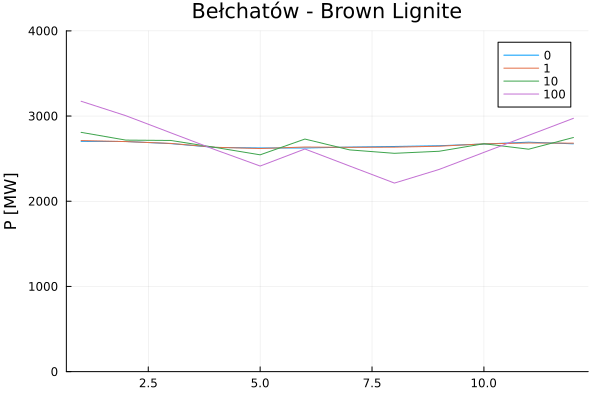

In [17]:
gen_id = 263
gen_name = "Bełchatów - Brown Lignite"

plot()
for noise ∈ ["0", "1", "10", "100"]
    P = DataDrop.retrieve_matrix("$(test_dir)/P_result_12_$noise.h5")
    plot!(100 * P[gen_id, :], label=noise, title=gen_name)
end
ylabel!("P [MW]")
ylims!(0, 4000)

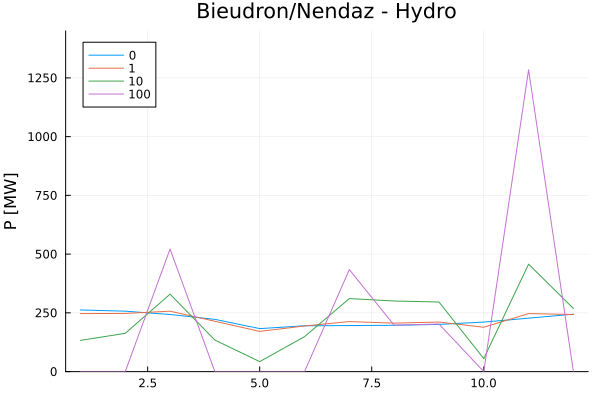

In [18]:
gen_id = 680
gen_name = "Bieudron/Nendaz - Hydro"

plot()
for noise ∈ ["0", "1", "10", "100"]
    P = DataDrop.retrieve_matrix("$(test_dir)/P_result_12_$noise.h5")
    plot!(100 * P[gen_id, :], label=noise, title=gen_name)
end
ylabel!("P [MW]")
ylims!(0, 1450)